# Digital Signal Processing Project
## Neural Network for Digital Signal Processing(NN4DSP)
### Dong Xu, Arthur Redfern, Diana Aleksieva

## 1. Introduction

The goal of project is ...

## 2. Background

## 3. Method

## 4. Implementation

### 4.1 Setup

In [410]:
import os
import time
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import onnx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt


### 4.2 Dataset Generation

In [336]:
_SAMPLE_DIR = "_assets"
YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)


In [337]:
dataset = torchaudio.datasets.YESNO(YESNO_DATASET_PATH, download=True)
print(len(dataset))

waveform, sample_rate, label = dataset[0]
waveform = waveform.numpy()
display(Audio(waveform[0],rate=sample_rate,))


60


[-3.93302727  5.34800009  8.31217974 ...  0.20711985 -3.58132164
  1.80829251] -27.61712100521804 25.916125584258783


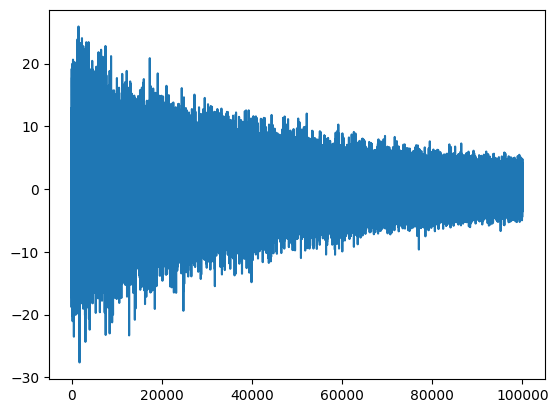

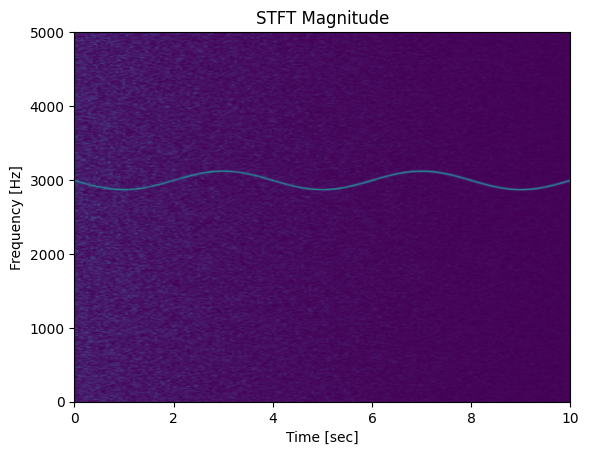

/home/edward/Work/NN4DSP/.venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


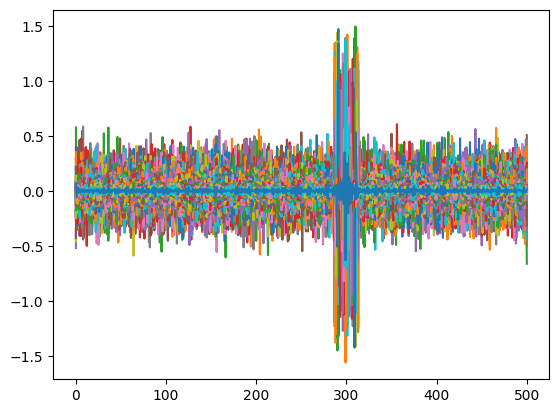

In [338]:
rng = np.random.default_rng()

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power),
                   size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

print(x, min(x), max(x))
plt.plot(x)
plt.show()
f, t, Zxx = signal.stft(x, fs, nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
plt.plot(Zxx)
plt.show()

3176


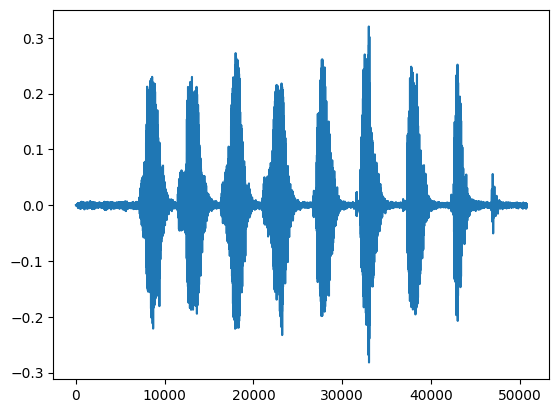

(50800,) [ 3.0517578e-05  6.1035156e-05  3.0517578e-05 ... -1.8615723e-03
 -2.2583008e-03 -1.3732910e-03] -0.28201294 0.32043457
(17, 3176)


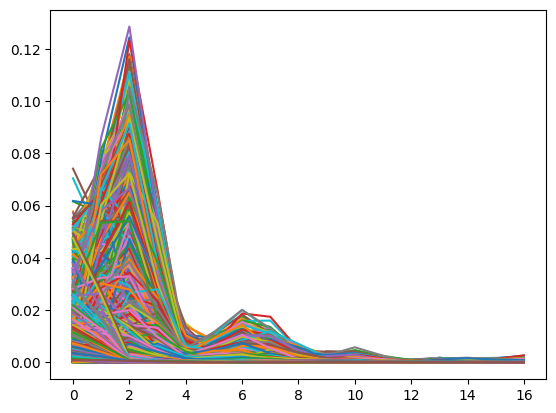

In [339]:
rng = np.random.default_rng()

wl = 32 # window_length

x = waveform[0]

data0 = []
for i in range((len(x) + wl//2)//(wl//2)):
    data0 += [x[wl//2*i : wl//2*i+wl]]
print(len(data0))

plt.plot(x)
plt.show()

print(x.shape, x, min(x), max(x))

f, t, Zxx = signal.stft(x, nperseg=wl)

print(np.abs(Zxx).shape)

plt.plot(np.abs(Zxx))
plt.show()

In [386]:
n_epochs = 64
learning_rate = 1e-4
momentum = 0.5
log_interval = 512
device = 'cpu'
train_batch_size = 64
test_batch_size = 64
window_length = 32

#model_name = 'NetS'
model_name = 'NetM'
#model_name = 'NetL'

(153040, 32) (153040, 17)
(30855, 32) (30855, 17)
153040 30855
2392 483
[6.1035156e-05, 6.1035156e-05, 0.00045776367, 0.000579834, 0.0009460449, 0.0009460449, 0.0013122559, 0.0026245117, 0.0026245117, 0.0018615723, 0.00061035156, 0.000579834, 0.0009460449, 0.0028076172, 0.0032958984, 0.0032958984, 0.001953125, 0.0014343262, 0.0038452148, 0.0038452148, 0.0027160645, 0.0021362305, 0.0015869141, 0.0035095215, 0.0035095215, 0.0032958984, 0.0031738281, 0.0019226074, 0.00030517578, 0.0046081543, 0.0046081543, 0.0039367676, -0.00015258789, -0.001739502, -0.0009765625, 0.0022888184, 0.002960205, 0.002960205, 0.0020751953, -0.00018310547, 0.002532959, 0.003692627, 0.003692627, 0.0023498535, 0.00079345703, 0.003112793, 0.0040283203, 0.0040283203, 0.002319336, -0.0004272461, -0.0018920898, 0.00088500977, 0.0039978027, 0.004211426, 0.004211426, 0.0027160645, 0.0045776367, 0.0057678223, 0.0057678223, 0.0049743652, 0.0017700195, 0.00021362305, 0.0025024414, 0.0029296875, 0.0029296875, 0.00091552734,

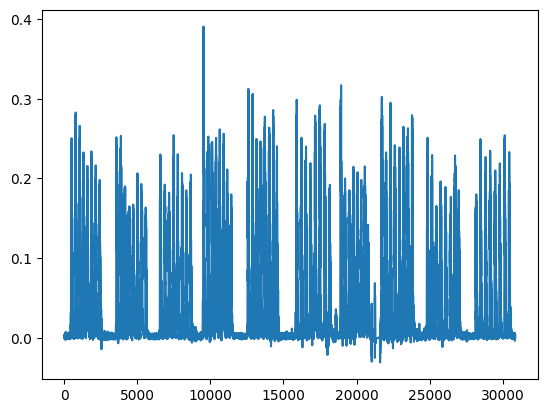

In [361]:

# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class STFTDataset(Dataset):

    def __init__(self, dataset, wl=32):
        data = []
        label = []
        for x,_,_ in dataset:
            x = x[0].numpy()
            for i in range((len(x) + wl//2)//(wl//2)):
                temp = list(x[wl//2*i : wl//2*i+wl])
                
                temp += [0] * (wl-len(temp))
                if len(temp) != wl:
                    print(len(temp))
                    
                data += [temp]
            
            f, t, Zxx = signal.stft(x, fs, nperseg=wl)
            
            for y in np.abs(Zxx).T:
                label += [y]
            
        self.data = np.array(data, dtype=np.float32)
        self.label = np.array(label, dtype=np.float32)
        print(self.data.shape, self.label.shape)
        assert len(self.data) == len(self.label)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx], self.label[idx]

train_dataset = STFTDataset([dataset[i] for i in range(50)], wl=window_length)
test_dataset = STFTDataset([dataset[i] for i in range(50,60)], wl=window_length)

print(len(train_dataset), len(test_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
print(len(train_dataloader), len(test_dataloader))

mm = [max(x) for x,y in test_dataset]
print(mm)
print(np.where(np.array(mm)==0.22021484))
plt.plot(mm)

### 4.3 Neural Network Architectures

In [388]:
class NetS(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetS, self).__init__()
        self.fc1 = nn.Linear(dim_in, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, dim_out)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.out(x)
        return x


class NetM(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetM, self).__init__()
        self.fc1 = nn.Linear(dim_in, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.out = nn.Linear(512, dim_out)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.out(x)
        return x
    
class NetL(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(NetL, self).__init__()
        self.fc1 = nn.Linear(dim_in, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 512)
        self.fc6 = nn.Linear(512, 512)
        self.out = nn.Linear(512, dim_out)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.out(x)
        return x

model = eval(model_name)(32, 17).to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)
print(model)

NetM(
  (fc1): Linear(in_features=32, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=17, bias=True)
)


### 4.4 Neural Network Training

In [377]:
# https://github.com/pytorch/examples/blob/main/mnist/main.py

def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        #if batch_idx % log_interval == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(train_loader.dataset),
        #        100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item()
    test_loss /= len(test_loader.dataset)

    print('Iter: {} Test set: Average loss: {:.4f}\n'.format(epoch, test_loss))
    return test_loss

Iter: 1 Test set: Average loss: 0.0167

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Iter: 2 Test set: Average loss: 0.0141

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Iter: 3 Test set: Average loss: 0.0120

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Iter: 4 Test set: Average loss: 0.0102

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Iter: 5 Test set: Average loss: 

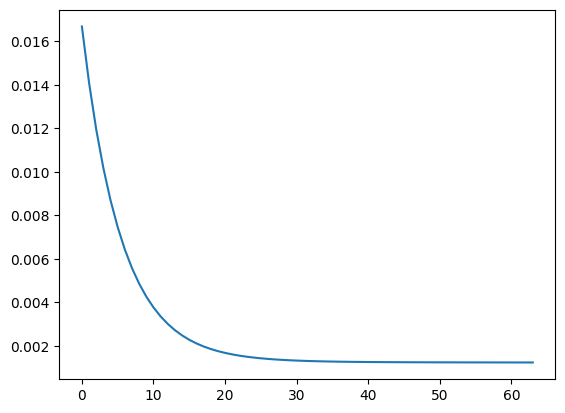

In [389]:
losses = []
for epoch in range(1, n_epochs + 1):
    train(model, device, train_dataloader, optimizer, epoch, 1000)
    loss = test(model, device, test_dataloader, epoch)
    losses += [loss]
    
    path = f'res/{model_name}_{epoch}'
    torch.save(model.state_dict(), f'{path}.pt')
    torch.onnx.export(model,                                # model being run
                  torch.randn(window_length).to(device),    # model input (or a tuple for multiple inputs)
                  f"{path}.onnx",           # where to save the model (can be a file or file-like object)
                  input_names = ['input'],              # the model's input names
                  output_names = ['output'])            # the model's output names
print(losses)
plt.plot(losses)

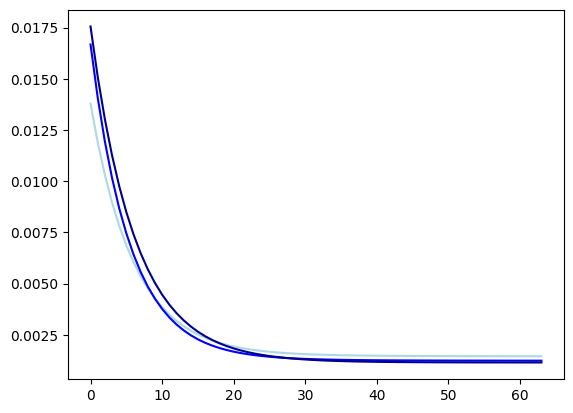

In [390]:
# net_s
losses = [0.013794145123525099, 0.011910912188790524, 0.010318274033685845, 0.008972969087267246, 0.007835484226781339, 0.006871830617815493, 0.006054938058280574, 0.005361836697598984, 0.004773933932805753, 0.004275088411671496, 0.0038519725876010194, 0.0034929729114932385, 0.0031880283837205604, 0.0029293142152270126, 0.0027096061222828725, 0.0025229652161558895, 0.0023644734427557446, 0.0022299030391833537, 0.0021156372489014364, 0.002018523062672149, 0.0019360478179478902, 0.001866001709453548, 0.0018064366772938703, 0.0017558138793401675, 0.001712823156545096, 0.001676237001713879, 0.0016450950422516963, 0.0016185708945244913, 0.001595963523899006, 0.0015766948349550524, 0.0015602525832981785, 0.001546202821355525, 0.001534187432672521, 0.0015239099129594367, 0.0015151031656856911, 0.0015075463038499298, 0.0015010496278797048, 0.0014954589340661346, 0.0014906409371471003, 0.0014864826100733383, 0.0014828843306152418, 0.0014797606815215307, 0.0014770424736745497, 0.0014746669516208237, 0.0014725842745257794, 0.0014707532613229576, 0.001469135621403833, 0.0014677000999087874, 0.0014664175997459073, 0.0014652676963365226, 0.0014642308196821088, 0.0014632911959008346, 0.0014624327260006616, 0.0014616452870288934, 0.0014609183031166755, 0.0014602440362049137, 0.0014596142419684075, 0.0014590237947901357, 0.0014584660488512083, 0.0014579367602802118, 0.0014574326993603264, 0.0014569501404164097, 0.0014564860768430871, 0.0014560381547908422]
plt.plot(losses, color='lightblue')
# net_m
losses = [0.016676212237519125, 0.014094289459965445, 0.011951227188641587, 0.010172414483861393, 0.008693016003415875, 0.007459854109179855, 0.0064319352732690295, 0.005575376422811687, 0.004861533632699664, 0.004266476450544415, 0.0037704098368435738, 0.0033567658306650782, 0.003011846162041936, 0.0027241413100462467, 0.0024840750639617995, 0.0022837359612749375, 0.0021164575684045955, 0.001976682970415317, 0.0018598657176550524, 0.0017622631638873928, 0.0016805955560328875, 0.0016122179042039042, 0.0015549184342481352, 0.0015068312531741305, 0.0014664485224473902, 0.0014324893978738434, 0.0014039264167105866, 0.0013798506285290753, 0.0013595399024362521, 0.0013423876997323086, 0.0013278970996220057, 0.0013156238708206232, 0.0013052241425171042, 0.0012963999384536366, 0.0012888953194527457, 0.0012824947394163811, 0.0012770341626401514, 0.0012723674440569, 0.0012683667048293957, 0.0012649351070369251, 0.0012619791645843434, 0.0012594284667609176, 0.0012572196960673183, 0.0012552946228612462, 0.0012536167727641156, 0.0012521449237273502, 0.001250845244300122, 0.0012496928737008785, 0.0012486684214268824, 0.001247750528633964, 0.0012469249221509415, 0.0012461801351572798, 0.001245501002820797, 0.0012448812208075474, 0.0012443126992732552, 0.0012437859796418631, 0.0012432955540179376, 0.0012428381524043162, 0.0012424084321243935, 0.0012420025392895946, 0.001241615254252671, 0.0012412473152199493, 0.0012408940586362718, 0.0012405547018495985]
plt.plot(losses, color='blue')
# net_l
losses = [0.0175542369694981, 0.015113209536426787, 0.013038057200894366, 0.011273500372797101, 0.009772612925137756, 0.00849641858734549, 0.0074131494072563085, 0.0064907159464920655, 0.005705118518225514, 0.005036089840984831, 0.004466121341218788, 0.003980674665753873, 0.0035669116853576216, 0.003214124243647908, 0.0029132898960922355, 0.002656770971778909, 0.0024378666561564754, 0.0022510393822254477, 0.0020915991742585867, 0.0019555117856464247, 0.0018393395474025735, 0.001740079594625417, 0.0016553020237574814, 0.0015828584616192154, 0.001520981688280002, 0.0014681018995499325, 0.0014228805943009334, 0.0013841750275849537, 0.001351044905033754, 0.0013226836495550587, 0.0012983979897404864, 0.0012776105670858156, 0.0012598047393498353, 0.001244549534392693, 0.0012314837661833947, 0.0012202838056735432, 0.0012106793838820408, 0.0012024414700247243, 0.0011953810794033584, 0.0011893289538592057, 0.0011841337535795343, 0.001179669760067992, 0.0011758376052505028, 0.001172545672777821, 0.0011697156393873046, 0.0011672787877574523, 0.0011651801874233599, 0.0011633673323545647, 0.0011618002036532374, 0.001160443631667729, 0.0011592696429299847, 0.001158252167342654, 0.0011573690829384759, 0.0011566019214142196, 0.0011559353473914263, 0.0011553537184087307, 0.0011548480091037284, 0.001154405741979978, 0.0011540192548454827, 0.0011536807389807646, 0.001153383821210071, 0.0011531244300042036, 0.001152895771009566, 0.0011526942737261686]

plt.plot(losses, color='darkblue')

[-0.047576904, -0.008758545, 0.021911621, 0.039398193, 0.05706787, 0.08129883, 0.09283447, 0.090423584, 0.0765686, 0.043182373, 0.031555176, 0.020751953, -0.0010986328, -0.023101807, -0.031707764, -0.029785156, -0.020812988, -0.003326416, 0.0019836426, 0.0021362305, 0.012542725, 0.009735107, -0.017059326, -0.04559326, -0.0809021, -0.106536865, -0.11932373, -0.15481567, -0.18508911, -0.13092041, -0.049346924, -0.028411865]
Time of NN (s): 0.01677703857421875
tensor([ 0.0014,  0.0106,  0.0099,  0.0046,  0.0021,  0.0004, -0.0007,  0.0018,
         0.0005, -0.0005,  0.0029,  0.0018, -0.0015, -0.0015, -0.0027,  0.0009,
         0.0044], grad_fn=<AddBackward0>)
Time of Scipy rfft (s): 0.00017333030700683594


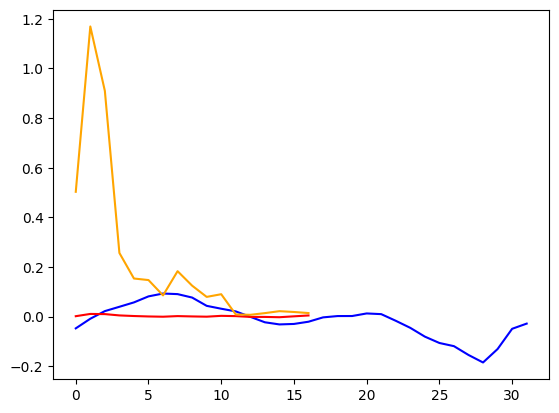

In [400]:
test_x, text_y = test_dataset[1042]

plt.plot(test_x, 'blue')
print(list(test_x))

start = time.time()
pred = model(torch.tensor(test_x))
end = time.time()
print('Time of NN (s):', end - start)
print(pred)


start = time.time()
label = scipy.fft.rfft(test_x)
label_magnitude = np.abs(label)
end = time.time()
print('Time of Scipy rfft (s):',end - start)

plt.plot(pred.detach().numpy(), 'red')
plt.plot(label_magnitude, 'orange')
plt.show()

### 4.5 Neural Network Verification

In [436]:
# generate property
center_point = [-0.047576904, -0.008758545, 0.021911621, 0.039398193, 0.05706787, 0.08129883, 0.09283447, 0.090423584, 0.0765686, 0.043182373, 0.031555176, 0.020751953, -0.0010986328, -0.023101807, -0.031707764, -0.029785156, -0.020812988, -0.003326416, 0.0019836426, 0.0021362305, 0.012542725, 0.009735107, -0.017059326, -0.04559326, -0.0809021, -0.106536865, -0.11932373, -0.15481567, -0.18508911, -0.13092041, -0.049346924, -0.028411865]

epsilon = 0.01
gamma = 0.01


nnv_lines = ['from dnnv.properties import *',
            'import numpy as np',
            '',
            'N = Network("N")',
            f'x = np.array({center_point}, dtype=np.float32)',
            f'epsilon = {epsilon}',
            f'gamma = {gamma}',
            'Forall(',
            '    x_,',
            '    Implies(',
            '        ((x - epsilon) < x_ < (x + epsilon)),',
            
            #'        np.argmax(N[input_layer:](x_)) == np.argmax(N[input_layer:](x)),',
            #'        np.argmax(N(x_)[0]) == np.argmax(N(x)),',
            '        ((N(x_)[0] - N(x))[0] <= gamma),',
            '    ),',
            ')']
nnv_lines = [x+'\n' for x in nnv_lines]
open(f'properties/robustness_{epsilon}_{gamma}.dnnp', 'w').writelines(nnv_lines)



In [421]:
# run verifiers
verifier = 'neurify'
verifier = 'eran'
# verifier = 'nnenum'

cmd = f'./run_DNNV.sh properties/robustness_0.01_0.01.dnnp --network N res/NetS_50.onnx --{verifier}'
os.system(cmd)

2023-04-29 23:45:11.581931: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-29 23:45:11.582444: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Verifying property:
Forall(x_, ((([-0.058 -0.019 ... -0.059 -0.038] < x_) & (x_ < [-0.038 0.001 ... -0.039 -0.018])) ==> ((N(x_)[0] - N([-0.048 -0.009 ... -0.049 -0.028])[0]) <= 0.01)))

Verifying Networks:
N:
Input_0                         : Input([32], dtype=float32)
MatMul_0                        : MatMul(Input_0, ndarray(shape=(32, 128)))
Add_0                           : Add(ndarray(shape=(128,)), MatMul_0)
Relu_0                          : Relu(Add_0)
MatMul_1                        : MatMul(Relu_0, ndarray(shape=(128, 128)))
Add_1                           : Add(ndarray(shape=(128,)), MatMul_1)
Relu_1                          : Relu(Add_1)
MatMul_2                        : MatMul(Relu_1, ndarray(shape=(128, 17)))
Add_2                           : Add(ndarray(shape=(17,)), MatMul_2)



2023-04-29 23:45:13.964652: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-29 23:45:13.964732: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-29 23:45:13.964837: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eOS): /proc/driver/nvidia/version does not exist
2023-04-29 23:45:13.965278: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Traceback (most recent call last):
  File "/home/edward/Work/DNNVWB/dnnv/nn/converters/tensorflow.py", line 58, in wrap

256

## 5. Conclusion and Future Work